In [1]:
'''
the cat sat on the mat
RNN 계열 : 왼쪽 -> 오른쪽 멀리떨어진 단어들은 서로 영향을 주고 받기 어려움

The cat that the boy who lived here adopted is sleeping
cat VS sleeping

self-attention
Q : 찾고 싶은 정보
K : 가진 정보
V : 최종 전달할 정보

비교대상        유사도              의미
cat vs the      낮음                the 의미없음
cat vs cat      높음                자기자신
cat vs sat      중간                동사와 연결
cat vs on       낮음                on 전치사...
cat vs mat      낮음                의미적으로 멀다

softmax로 중요도 확률처럼 변경      유사도를 가중치로 변환
단어            가중치
the             0.05
sat             0.3
mat             0.05
cat             0.6

cat이 보는 시점은
Query(cat) -> compare with -> Key(the) -> key(cat) -> key(sat)

가중치
the : 01  cat: 0.7   sat : 0.2
출력 : 0.1*value(the) + ......

RNN 순차처리
self-attention 병렬처리

다중의미처리
river bank  river를 강하게 참조
bank  loan  loan을 강하게 참조
'''

'\nthe cat sat on the mat\nRNN 계열 : 왼쪽 -> 오른쪽 멀리떨어진 단어들은 서로 영향을 주고 받기 어려움\n\nThe cat that the boy who lived here adopted is sleeping\ncat VS sleeping\n\nself-attention\nQ : 찾고 싶은 정보\nK : 가진 정보\nV : 최종 전달할 정보\n\n비교대상        유사도              의미\ncat vs the      낮음                the 의미없음\ncat vs cat      높음                자기자신\ncat vs sat      중간                동사와 연결\ncat vs on       낮음                on 전치사...\ncat vs mat      낮음                의미적으로 멀다\n\nsoftmax로 중요도 확률처럼 변경      유사도를 가중치로 변환\n단어            가중치\nthe             0.05\nsat             0.3\nmat             0.05\ncat             0.6\n\ncat이 보는 시점은\nQuery(cat) -> compare with -> Key(the) -> key(cat) -> key(sat)\n\n가중치\nthe : 01  cat: 0.7   sat : 0.2\n출력 : 0.1*value(the) + ......\n\nRNN 순차처리\nself-attention 병렬처리\n\n다중의미처리\nriver bank  river를 강하게 참조\nbank  loan  loan을 강하게 참조\n'

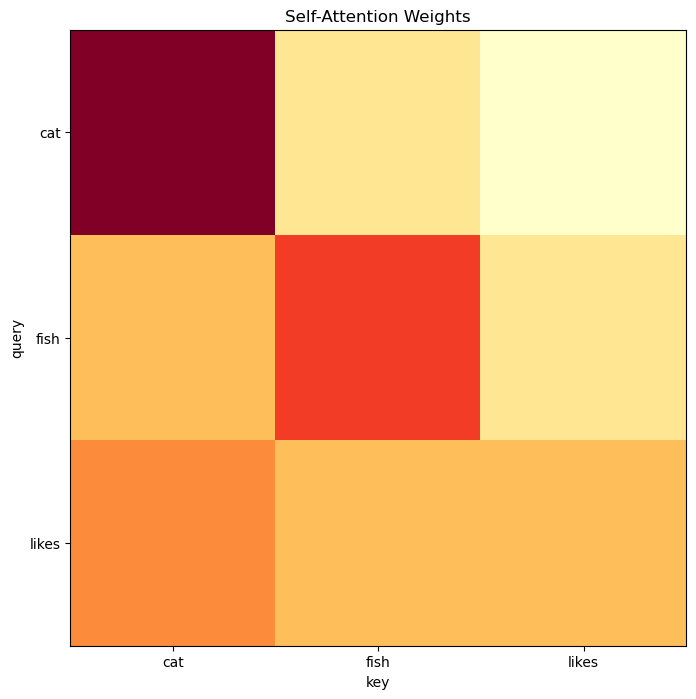

In [2]:
# self-attention 시각화
import numpy as np
import matplotlib.pyplot as plt

words = ['cat', 'fish', 'likes'] # 고양이가 생선을 좋아한다.
# 가상의 attention 가중치
# 각 행은 해당 단어가 다른단어들에게 주목하는 정도
attention_weights = np.array([
    [0.7, 0.2, 0.1],    #고양이는 자기 자신에게 가장 높은 가중치
    [0.3, 0.5, 0.2],    #생선에 대해 가장 높은 가중치
    [0.4, 0.3, 0.3]     #좋아한다에 대해 가장 높은 가중치
])
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attention_weights, cmap='YlOrRd')
ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)
ax.set_xlabel('key')
ax.set_ylabel('query')
ax.set_title('Self-Attention Weights')
plt.show()


In [3]:
# Beam Search
# 문장을 생성할 때 다음에 나올단어는 수천~수만개가 될 수 있는데, 이걸 경우의 수로 따지면.... X
# 상위 N개의 후보만 유지, N을 beam size라고 함
# beam size = 1 매번 가장 좋은 것만 선택(Greedy)
# beam size = 4 4개의 가능성을 동시에 탐색

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer # Hugging Face Transformers 라이브러리에서 시퀀스-투-시퀀스 모델과 토크나이저를 로드하기 위한 클래스
import torch # PyTorch 딥러닝 프레임워크, GPU 가속 및 텐서 연산을 위해 사용
import time # 시간 관련 함수를 제공하는 표준 라이브러리, 주로 코드 실행 시간 측정에 사용

MODEL_NAME = "t5-small" # 사용할 T5 모델의 이름을 정의합니다. 여기서는 't5-small' 버전을 사용합니다.

# AutoTokenizer.from_pretrained()를 사용하여 사전 훈련된 모델에 맞는 토크나이저를 로드합니다.
# 토크나이저는 텍스트를 모델이 이해할 수 있는 숫자 ID 시퀀스로 변환하는 역할을 합니다.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# AutoModelForSeq2SeqLM.from_pretrained()를 사용하여 사전 훈련된 시퀀스-투-시퀀스 모델을 로드합니다.
# 이 모델은 텍스트 요약, 번역 등 시퀀스-투-시퀀스 태스크에 사용됩니다.
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# PyTorch를 사용하여 모델을 실행할 장치(device)를 설정합니다.
# CUDA(GPU)가 사용 가능하면 GPU를 사용하고, 그렇지 않으면 CPU를 사용합니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
# 모델을 선택된 장치로 이동시켜 해당 장치에서 연산이 수행되도록 합니다.
model = model.to(device)

text = """summarize: The Amazon rainforest is the world's largest tropical rainforest. 
    It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. 
    The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth. 
    However, deforestation poses a significant threat to this vital ecosystem."""

print(f'원본 : {text}')
print(text.replace("summarize",""))
# 입력 텍스트를 토크나이저를 통해 모델 입력 형식으로 변환합니다.
# 'return_tensors="pt"'는 PyTorch 텐서로 반환하도록 지정합니다.
# 'max_length=512'는 입력 시퀀스의 최대 길이를 512로 제한합니다.
# 'truncation=True'는 최대 길이를 초과하는 경우 텍스트를 자르도록 합니다.
# '.to(device)'는 생성된 텐서를 모델이 있는 장치(CPU 또는 GPU)로 이동시킵니다.
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)

# 다양한 빔 크기(num_beams)를 실험하기 위한 리스트를 정의합니다.
beam_size = [1,2,4,8] # 빔 서치(beam search) 디코딩 전략에서 사용할 빔의 개수들을 정의한 리스트입니다. 각 숫자는 요약 생성 시 고려할 후보 시퀀스의 수를 나타냅니다.
# 각 빔 크기에서의 결과(빔 크기, 요약 텍스트, 소요 시간)를 저장할 리스트를 초기화합니다.
results = []
# 정의된 각 빔 크기에 대해 반복합니다.
for num_beams in beam_size:
    # 현재 실험 중인 빔 크기를 출력합니다.
    print(f'beam size : {num_beams}')
    # 현재 빔 크기에서의 요약 생성 시작 시간을 기록합니다.
    start_time = time.time()
    # 모델의 'generate' 메서드를 사용하여 요약을 생성합니다.
    outputs= model.generate(
        # 'inputs'는 토크나이징된 입력 텍스트를 전달합니다.
        **inputs,
        # 현재 반복의 빔 크기를 설정합니다.
        num_beams=num_beams,
        # 생성될 요약문의 최대 길이를 60으로 제한합니다.
        max_length=60,
        # 생성될 요약문의 최소 길이를 20으로 설정합니다.
        min_length=20,
        # 'early_stopping=True'는 모든 빔이 EOS(문장 끝) 토큰에 도달하거나 최대 길이에 도달하면 생성을 중지합니다.
        early_stopping=True,
        # 'no_repeat_ngram_size=3'은 3-gram이 반복되지 않도록 하여 텍스트의 자연스러움을 높입니다.
        no_repeat_ngram_size=3,
        # 생성할 시퀀스의 수를 1로 설정합니다 (가장 좋은 하나의 요약).
        num_return_sequences=1
        )
    # 요약 생성에 걸린 시간을 계산합니다.
    elapsed_time = time.time() - start_time
    # 생성된 토큰 ID 시퀀스를 사람이 읽을 수 있는 텍스트로 디코딩합니다.
    # 'skip_special_tokens=True'는 EOS, BOS 같은 특수 토큰을 결과에서 제외합니다.
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # 현재 빔 크기, 생성된 요약, 소요 시간을 결과 리스트에 추가합니다.
    results.append((num_beams, summary, elapsed_time))
    print(f'요약 : {summary}')


c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


원본 : summarize: The Amazon rainforest is the world's largest tropical rainforest. 
    It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. 
    The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth. 
    However, deforestation poses a significant threat to this vital ecosystem.
: The Amazon rainforest is the world's largest tropical rainforest. 
    It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. 
    The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth. 
    However, deforestation poses a significant threat to this vital ecosystem.
beam size : 1
요약 : the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other South american countries.
beam size : 2
요약 : the amazon rainforest covers much of northwestern Brazil. it extends in

In [5]:
for num_beams, summary, elapsed_time in results:
    print(f'beam size : {num_beams}')
    print(f'측정 시간 : {elapsed_time}초')
    print(f'요약 : {summary}')

beam size : 1
측정 시간 : 0.4722015857696533초
요약 : the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other South american countries.
beam size : 2
측정 시간 : 0.4067976474761963초
요약 : the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.
beam size : 4
측정 시간 : 0.5565969944000244초
요약 : the amazon rainforest covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. deforestation poses a significant threat to this vital ecosystem.
beam size : 8
측정 시간 : 0.5874490737915039초
요약 : the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.


In [7]:
'''
ROUGE 매트릭
문서를 요약했는데 어떻게 품질을 측정
겹침 정도를 측정
ROGUE-1 단어단위
    정답: 고양이가 생선을 먹었다.
    생성: 고양이가 물고기를 먹었다
    겹침: 고양이가 먹었다 2/4 0.5
ROGUE-2 2개 단위 : 순서도 고려
ROGUE-L 가장 긴 공통 부분수열(순서는 유지하지만 연속적이지 않아도 됨.)

    단점: 의미는 같지만 다른표현을 쓰면 점수가 낮다.
        자동차 VS 차량 겹침 없음으로 판단.
'''

'\nROUGE 매트릭\n문서를 요약했는데 어떻게 품질을 측정\n겹침 정도를 측정\nROGUE-1 단어단위\n    정답: 고양이가 생선을 먹었다.\n    생성: 고양이가 물고기를 먹었다\n    겹침: 고양이가 먹었다 2/4 0.5\nROGUE-2 2개 단위 : 순서도 고려\nROGUE-L 가장 긴 공통 부분수열(순서는 유지하지만 연속적이지 않아도 됨.)\n\n    단점: 의미는 같지만 다른표현을 쓰면 점수가 낮다.\n        자동차 VS 차량 겹침 없음으로 판단.\n'

In [9]:
# 토크나이져

In [20]:
# 배치처리, 데이터 콜레이터(배치를 만들 때 길이를 맞춰주는 작업)
# 효율적인 데이터 처리방법

from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import torch, time
# AutoModelForSeq2SeqLM: 입력을 받아서 다른 텍스트 생성하는 Seq2Seq 모델을 위한 자동로드
# Encoder-Decoder 모델을 자동으로
# T5, BART, MarianMT
# 번역/요약/QA/문장변환 입력->출력

# DataCollatorForSeq2Seq: 배치를 만들 때 길이를 맞춰주는 작업
# seq2seq 학습시 배치단위로 패딩-정렬-라벨 시프트 등을 자동처리하는 데이터 정렬 도구
# 배치생성 - 길이가 다른 문장들을 동일길이로 패딩
# 라벨 시프트 -라벨을 디코더 입력으로 사용 (teacher forcing에 필요한 작업)
# DataLoader 안에서 사용
MODEL_NAME = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device) 
model.eval()

texts = [
    "summarize: The cat sat on the mat.",
    "summarize: Python is a popular programming language.",
    "summarize: Machine learning is a subset of artificial intelligence.",
    "summarize: The weather is nice today.",
    "summarize: I love reading books in my free time.",
    "summarize: Coffee is one of the most popular beverages worldwide.",
    "summarize: Regular exercise is important for health.",
    "summarize: The Internet has changed how we communicate.",
]
# 개별처리 VS 배치처리
start_time = time.time()
result_indivisual = []
with torch.no_grad():
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)
        outputs = model.generate(**inputs, max_length=30)
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
        result_indivisual.append(summary)
time_individual = time.time() - start_time
print(f"소요시간 : {time_individual}")
print(f"문장당:, {time_individual/len(texts):.4f}")

    
    

c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


소요시간 : 0.9255599975585938
문장당:, 0.1157


In [24]:
# 배치처리
start_time = time.time()
result_batch = []
with torch.no_grad():
    outputs = model.generate(**inputs, max_length=30)
    for output in outputs:
        summary = tokenizer.decode(output, skip_special_tokens=True)
        result_batch.append(summary)
time_indivisual = time.time() - start_time
print(f"소요시간 : {time_indivisual}")
print(f"문장당:, {time_indivisual/len(texts):.4f}")  

소요시간 : 0.16839075088500977
문장당:, 0.0210


In [ ]:
# 데이터콜레이터
start_time = time.time()
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)
tokenized =[]
for text in texts:
    encoded = tokenizer(text, truncation=True)
    tokenized.append(encoded)

batch = data_collator(tokenized)
print(batch)

{'input_ids': tensor([[21603,    10,    37,  1712,     3,     7,   144,    30,     8,  6928,
             5,     1,     0,     0],
        [21603,    10, 20737,    19,     3,     9,  1012,  6020,  1612,     5,
             1,     0,     0,     0],
        [21603,    10,  5879,  1036,    19,     3,     9,   769,  2244,    13,
          7353,  6123,     5,     1],
        [21603,    10,    37,  1969,    19,  1245,   469,     5,     1,     0,
             0,     0,     0,     0],
        [21603,    10,    27,   333,  1183,  1335,    16,    82,   339,    97,
             5,     1,     0,     0],
        [21603,    10, 10429,    19,    80,    13,     8,   167,  1012, 18928,
          4388,     5,     1,     0],
        [21603,    10, 17116,  2510,    19,   359,    21,   533,     5,     1,
             0,     0,     0,     0],
        [21603,    10,    37,  1284,    65,  2130,   149,    62,  4521,     5,
             1,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 